# A Deep Learning approach to Noise Tagging

In [2]:
import torch
import torch.utils.data
from matplotlib import pyplot as plt
import numpy as np
import os
import sklearn as sk
from scipy.io import loadmat
import scipy.io as sio
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.model_selection import cross_val_score
import sys, os
import pickle
from scipy import stats
import types

## EEG2CodeV2 Model Definition

In [3]:
## EEG2Code Network
class EEG2CodeV2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # first spatial filter
        self.conv2d_1 = torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(8, 1),
                                        padding=(0, 0), stride=(1, 1))
        self.relu_1_1 = torch.nn.ReLU()
        self.batch_1 = torch.nn.BatchNorm2d(num_features=16, affine=False)
        self.relu_1_2 = torch.nn.ReLU()
        self.maxpool2d_1 = torch.nn.MaxPool2d(kernel_size=(2, 1), stride = (1, 1), padding=(1, 0)) # !!

        #  Second Temporal Filter
        self.conv2d_2 = torch.nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 12),
                                        padding=(0, 0))
        self.batch_2 = torch.nn.BatchNorm2d(num_features=8, affine=False)
        self.relu_2 = torch.nn.ReLU()
        self.maxpool2d_2 = torch.nn.MaxPool2d(kernel_size=(1, 2), padding=(0, 0))
        self.dropout_2 = torch.nn.Dropout(p=0.5)

        # Third layer
        self.conv2d_3 = torch.nn.Conv2d(in_channels=8, out_channels=4, kernel_size=(1, 5),
                                        padding=(0, 2))
        self.batch_3 = torch.nn.BatchNorm2d(num_features=4, affine=False)
        self.relu_3 = torch.nn.ReLU()
        self.maxpool2d_3 = torch.nn.MaxPool2d(kernel_size=(1, 2), padding=(0, 0))
        self.dropout_3 = torch.nn.Dropout(p=0.5)

        # Fourth layer
        self.flatten_4 = torch.nn.Flatten(start_dim = 1)
        self.dense_4 = torch.nn.Linear(in_features=40, out_features=256)
        self.relu_4 = torch.nn.ReLU()
        self.dropout_4 = torch.nn.Dropout(p=0.5)

        # Fifth layer
        self.dense_5 = torch.nn.Linear(in_features=256, out_features=2)
        self.softmax_5 = torch.nn.Softmax(dim=1)

    def forward(self, x):
        
        # layer 1
        #print(x.shape,"input of layer 1")
        #print("layer 1")
        x = self.conv2d_1(x)
        #print(x.shape)
        #x = self.relu_1_1(x)
        x = self.batch_1(x)
        #print(x.shape)
        x = self.relu_1_2(x)
        #print(x.shape)
        x = self.maxpool2d_1(x)
        #print(x.shape,"output of layer 1/ input of layer 2")
        
        # layer 2
        #print("layer 2")
        x = self.conv2d_2(x)
        #print(x.shape)
        x = self.batch_2(x)
        #print(x.shape)
        x = self.relu_2(x)
        #print(x.shape)
        x = self.maxpool2d_2(x)
        #print(x.shape)
        x = self.dropout_2(x)
        #print(x.shape,"output of layer 2/ input of layer 3")
        
        # layer 3
        #print("layer 3")
        x = self.conv2d_3(x)
        #print(x.shape)
        x = self.batch_3(x)
        #print(x.shape)
        x = self.relu_3(x)
        #print(x.shape)
        x = self.maxpool2d_3(x)
        #print(x.shape,"output of layer 3/input of layer 4")
        # x = self.dropout_3(x)
        
        # layer 4
        x = self.flatten_4(x) # !! h = h.view(-1, np.prod(h.size()[1:]))
        #print(x.shape)
        x = self.dense_4(x)
        #print(x.shape)
        x = self.relu_4(x)
        #print(x.shape)
        x = self.dropout_4(x)
        #print(x.shape,"output of layer 4/input of layer 5")
        
        # layer 5
        x = self.dense_5(x)
        #print(x.shape, "output of layer 5 pre softmax")
        #x = self.softmax_5(x)
        
        return x

    # Is dropout handig voor trainen?
    # tijdens trainen dropout aan, en tijdens testen uit met delen door 2 of keer 2
    # Of dropout aan tijdens trainen en tijdens testen, je krijgt een distributie als je dezelfde sample elke keer krijgt
    # distributie piek gebruiken voor early stopping
    # hou verhoudt kans tot distributie

### Functions for the model

In [3]:
def fit(X, labels,X_test,labels_test):
    sm = torch.nn.Softmax(dim = 1)
    batch = 256
    
    dataset = torch.utils.data.DataLoader(Dataset(X, labels), batch_size=batch, shuffle=True)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()
    
    losses = np.zeros((25,))
    accuracy = np.zeros((25,))
    testaccuracy = np.zeros((25,))
    testloss = np.zeros((25,))
    
    for i in range(25):
        loss_sum = 0.0
        acc_sum = 0.0
        counter = 0
        for phase in ["train", "valid"]:
            
            for x, t in dataset:
                if phase == "train":
                    model.train(True)
                    y = model(x)
                    #print(y)
                    loss = criterion(y, t[:, 0])
                    losses[i] += loss
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                else:
                    model.train(False)
                    y = model(x)
                    loss = criterion(y, t[:,0])
                    loss_sum += loss
                    acc = compute_accuracy(sm(y), t)
                    acc_sum += acc
                    counter += 1
                    
                    
        losses[i] = loss_sum/counter
        accuracy[i] = acc_sum/counter
    
        testaccuracy[i] = compute_accuracy(sm(model((torch.from_numpy(X_test).type(torch.float)))), 
                                           torch.from_numpy(labels_test).type(torch.long))
        
        testloss[i] = criterion(sm(model(torch.from_numpy(X_test).type(torch.float))),
                               torch.from_numpy(labels_test[:,0]).type(torch.long))
        
        print("Training Loss: {0} - Accuracy: {1} - Test Accuracy: {2} - Iteration: {3}"
              .format(losses[i],accuracy[i], testaccuracy[i], i + 1))

    return losses, accuracy, testaccuracy, testloss


In [132]:
def compute_accuracy(X, labels):
    torchsum = (torch.argmax(X, dim = 1) == labels[:,0]).sum()
    print(torchsum)
    return torch.true_divide(torchsum,X.shape[0])
    

In [5]:
def predict_epochs(X):
    model.train(False)
    
    softmax = torch.nn.Softmax(dim = 1)
    predicted_epochs = softmax(model(torch.from_numpy(X).type(torch.float)))
    return predicted_epochs.detach().numpy()

### Dataset Definition

In [6]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, labels):
        self.X = torch.from_numpy(X).type(torch.float)
        self.labels = torch.from_numpy(labels).type(torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        X = self.X[index, :, :, :]
        y = self.labels[index]
        return X, y

### Functions for slicing and reshaping

In [7]:
def slice_data(X, V, y, window_size, nr_epochs, step_size):

    sX = [X[:, i * step_size:i * step_size + window_size, :] for i in range(nr_epochs)]
    sV = [V[i * step_size, :] for i in range(nr_epochs)]

    sV = np.array(sV).astype(float)
    sX = np.array(sX).astype(float)
    sX = np.transpose(sX, (1, 2, 3, 0))

    labels = np.zeros((y.shape[0], sV.shape[0]))
    for i in range(y.shape[0]):
        letter_index = y[i, 0] - 1
        labels[i, :] = sV[:, letter_index]

    return sX, sV, labels

In [8]:
def XYreshape(X,Y):
    channels, window, trials, epochs = X.shape
    X = X.reshape(channels, window, trials*epochs, 1)
    X = np.transpose(X, (2, 3, 0, 1))
    
    Y = Y.reshape(trials * epochs, 1)
    return X, Y



### Dataloading and shaping

In [122]:
# Load data
# 8 channels = {'Fpz', 'T7', 'O1', 'POz', 'Oz', 'Iz', 'O2', 'T8'}
# Trial time is 31.5 seconds
# sampling frequency is 120
# Pre-processing done in Matlab:
# Downsampled
# High-pass filter of 2 Hz applied
# Low-pass filter of 30 Hz applied

subjectnumber = '30'

data = loadmat('Data/xsub-{}/xsub-{}_gdf.mat'.format(subjectnumber,subjectnumber))
X = data['X']  # EEG data: channels x samples x trials
V = data['V']  # Codes: bits x codes
y = data['y']  # Labels: 1 x trials

channels = ['Fpz', 'T7', 'O1', 'POz', 'Oz', 'Iz', 'O2', 'T8']

print(X.shape)
print(V.shape)
print(y.shape)
step_size = 2
window_size = 32
n_channels, n_samples, n_trials = X.shape  # Extracting data dimensions
nr_epochs = int(n_samples - (n_samples / step_size) - window_size)
train_test_size = int((4 / 5) * n_trials)
print(train_test_size)

# Extending the code book
V_ext = np.tile(V,(15,1))

# Slicing the data to epochs
sX, sV, labels = slice_data(X,V_ext,y,window_size,nr_epochs,step_size)

print(X.shape)
print(sV.shape[0])

X_train = sX[:, :, :train_test_size, :]
X_test = sX[:, :, train_test_size:, :]

labels_train = labels[:train_test_size, :]  # labels
labels_test = labels[train_test_size:, :]  # labels

X_train, labels_train = XYreshape(X_train, labels_train)
X_test, labels_test = XYreshape(X_test, labels_test)

print(X_test.shape[0])

X_val = X_test[int(X_test.shape[0]/2):, :, :, :]
X_test = X_test[:int(X_test.shape[0]/2), :, :, :]

labels_val = labels_test[int(labels_test.shape[0]/2):,:]
labels_test = labels_test[:int(labels_test.shape[0]/2),:]



cvX, cvLabels = XYreshape(sX,labels)



(8, 3780, 100)
(252, 20)
(100, 1)
80
(8, 3780, 100)
1858
37160


(8, 32, 185800) (185800,)


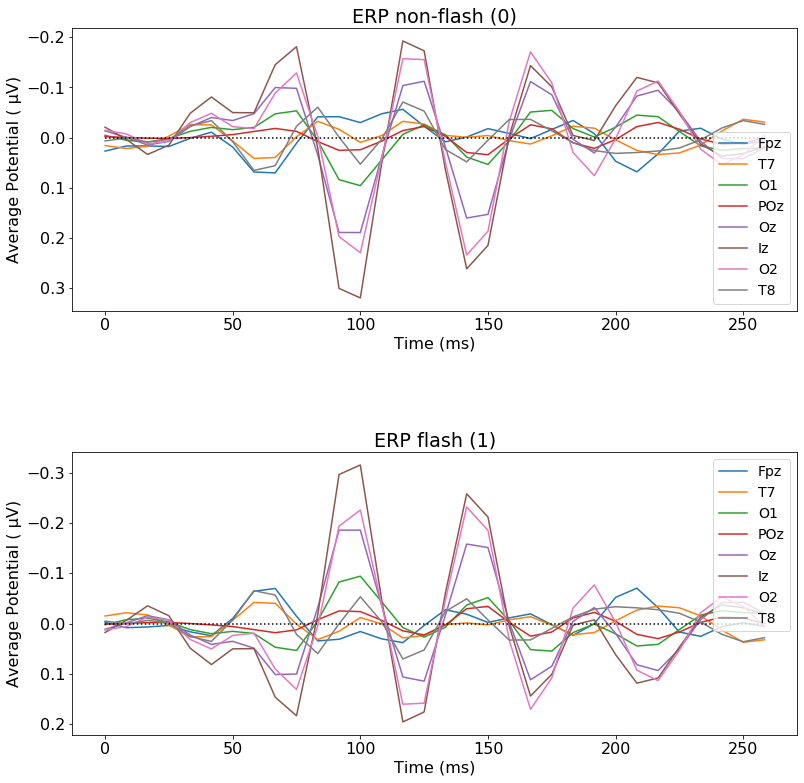

In [123]:
sX_ = np.reshape(sX,(sX.shape[0],sX.shape[1],-1))
labels_ = labels.flatten()
print(sX_.shape,labels_.shape)
x_axis = [i*8.33 for i in range(window_size)]


fig, sp = plt.subplots(2,figsize=(13,13))
plt.rcParams['font.size'] = '16'
sp[0].plot(x_axis,np.mean(sX_[:,:,labels_==0],axis=2).T,)
sp[0].set_title('ERP non-flash (0)')
sp[0].legend(channels, prop = {"size": 14})
sp[0].plot(x_axis, [0 for i in range(len(x_axis))],'k:')
sp[0].set_xlabel('Time (ms)')
sp[0].set_ylabel('Average Potential ( μV)')
sp[0].invert_yaxis()



sp[1].plot(x_axis,np.mean(sX_[:,:,labels_==1],axis=2).T)
sp[1].set_title('ERP flash (1)')
sp[1].legend(channels, prop = {"size": 14})
sp[1].plot(x_axis, [0 for i in range(len(x_axis))],'k:')
sp[1].set_xlabel('Time (ms)')
sp[1].set_ylabel('Average Potential ( μV)')
sp[1].invert_yaxis()

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
fig.savefig('results/{}/ERP_{}.pdf'.format(subjectnumber,subjectnumber))


### Fitting the Network

In [124]:
## fit model
model = EEG2CodeV2()
print(X_train.shape)
print(labels_train.shape)
losses, accuracy, testaccuracy, testloss = fit(X_train,labels_train,X_test,labels_test)

#fig2, sp2 = plt.subplots(2,figsize=(13,13))
#sp2[0].plot(losses)
#sp2[0].set_title("Losses")
#sp2[1].plot(accuracy)
#sp2[1].set_title("Accuracy")

# save the model to disk
modelname = 'results/{}/trained_model_{}.sav'.format(subjectnumber,subjectnumber)
pickle.dump(model, open(modelname, 'wb'))
networkdata = [losses, accuracy, testaccuracy,testloss]
pickle.dump(networkdata, open('results/{}/networkdata_{}.sav'.format(subjectnumber,subjectnumber),'wb'))



(148640, 1, 8, 32)
(148640, 1)
Training Loss: 0.6859933733940125 - Accuracy: 0.5483272671699524 - Test Accuracy: 0.535952627658844 - Iteration: 1
Training Loss: 0.676142156124115 - Accuracy: 0.5738247632980347 - Test Accuracy: 0.5592034459114075 - Iteration: 2
Training Loss: 0.6713040471076965 - Accuracy: 0.5813602805137634 - Test Accuracy: 0.5707212090492249 - Iteration: 3
Training Loss: 0.6684722304344177 - Accuracy: 0.5878254175186157 - Test Accuracy: 0.5751345753669739 - Iteration: 4
Training Loss: 0.6686933636665344 - Accuracy: 0.5917007327079773 - Test Accuracy: 0.5780947208404541 - Iteration: 5
Training Loss: 0.6655992865562439 - Accuracy: 0.5941547751426697 - Test Accuracy: 0.5796555280685425 - Iteration: 6
Training Loss: 0.6655271649360657 - Accuracy: 0.5929781794548035 - Test Accuracy: 0.582777202129364 - Iteration: 7
Training Loss: 0.6632816195487976 - Accuracy: 0.5986902713775635 - Test Accuracy: 0.5840150713920593 - Iteration: 8
Training Loss: 0.6625022888183594 - Accuracy

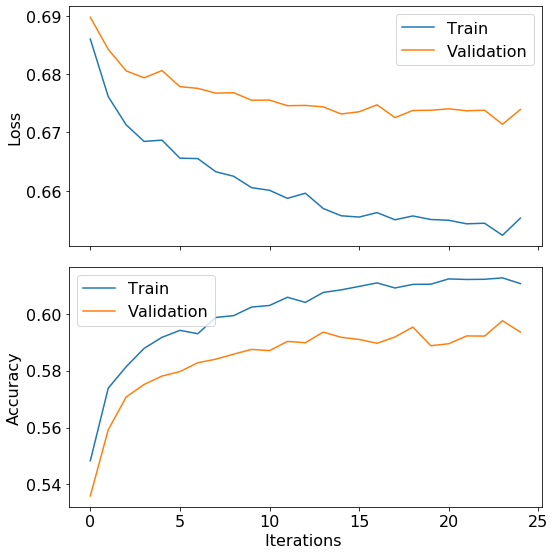

In [125]:
fig2, sp2 = plt.subplots(2,figsize=(8,8),sharex=True)
plt.rcParams['font.size'] = '16'
sp2[0].plot(losses)
sp2[0].plot(testloss)
sp2[0].legend(['Train','Validation'], loc='upper right', prop={"size":16})
sp2[0].set_ylabel('Loss')

sp2[1].plot(accuracy)
sp2[1].plot(testaccuracy)
sp2[1].set_xlabel('Iterations ')
sp2[1].set_ylabel('Accuracy')
sp2[1].legend(['Train', 'Validation'], loc='upper left', prop={"size":16})

#sp2[0].set_ylim([0.5,1])
#sp2[1].set_ylim([0.5,1])

fig2.tight_layout()
fig2.savefig('results/{}/network_iterations_{}.pdf'.format(subjectnumber,subjectnumber))
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

In [126]:
## predict with model
model_predictions = predict_epochs(X_test)
print(model_predictions)


[[0.49240488 0.5075951 ]
 [0.48423693 0.5157631 ]
 [0.4742425  0.52575755]
 ...
 [0.38008496 0.61991507]
 [0.4060246  0.59397537]
 [0.46990648 0.5300935 ]]


In [133]:
val_predictions = predict_epochs(X_val)
sm = torch.nn.Softmax(dim = 1)
print(val_predictions)
print(X_val.shape)
validation_accuracy = 100*compute_accuracy(sm(model(torch.from_numpy(X_val).type(torch.float))),
                                               torch.from_numpy(labels_val).type(torch.long)).detach().numpy()
print("Validation accuracy: {:.2f} % ".format(validation_accuracy))
pickle.dump(validation_accuracy, open('results/{}/model_acc_epoch_{}.sav'.format(subjectnumber,subjectnumber),'wb'))

[[0.51362884 0.4863712 ]
 [0.4616137  0.53838634]
 [0.50360847 0.4963916 ]
 ...
 [0.49639654 0.5036035 ]
 [0.47064933 0.5293507 ]
 [0.51697004 0.48303002]]
(18580, 1, 8, 32)
tensor(11280)
Validation accuracy: 60.71 % 


### Fitting the LDA 

In [128]:
##fit LDA + Epoch classification
d, i, c, w = X_train.shape
dt, it, ct, wt = X_test.shape

lda_X_train = X_train.reshape(d*i,c*w)
lda_labels_train = labels_train.reshape(d*i)
print(lda_X_train.shape, " X train set")
print(lda_labels_train.shape, " labels train set")

lda_X_test = X_test.reshape(dt*it,ct*wt)
lda_labels_test = labels_test.reshape(dt*it)
print(lda_X_test.shape, " X test set")
print(lda_labels_test.shape," labels test set")

clf = LDA()
clf.fit(lda_X_train, lda_labels_train)
score = clf.score(lda_X_test, lda_labels_test) * 100
print('LDA epoch accuracy: {:.2f}%'.format(score))

# Cross-Val
clf_ = LDA()
print(cvX.shape)
d1,d2,d3,d4 = cvX.shape

cvX = cvX.reshape(d1*d2,d3*d4)
cvLabels = cvLabels.reshape(d1*d2)


crossval = KFold(n_splits = 5)
cvscores = cross_val_score(clf_, cvX, cvLabels,cv = crossval)
for i in range(len(cvscores)):
    print('Cross-Validated LDA epoch accuracy of fold {}: {:.2f}%'.format(i+1,cvscores[i]*100))
    
pickle.dump(score, open('results/{}/LDA_acc_epoch_{}.sav'.format(subjectnumber,subjectnumber),'wb'))

(148640, 256)  X train set
(148640,)  labels train set
(18580, 256)  X test set
(18580,)  labels test set


C:\Users\smake\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA epoch accuracy: 59.09%
(185800, 1, 8, 32)


C:\Users\smake\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\smake\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\smake\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\smake\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\smake\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Cross-Validated LDA epoch accuracy of fold 1: 61.24%
Cross-Validated LDA epoch accuracy of fold 2: 60.61%
Cross-Validated LDA epoch accuracy of fold 3: 60.69%
Cross-Validated LDA epoch accuracy of fold 4: 61.79%
Cross-Validated LDA epoch accuracy of fold 5: 60.26%


In [129]:
ldaboolean = True

# Trial classification LDA
lda_trials = int(lda_X_test.shape[0]/sV.shape[0])
print(lda_trials)
lda_epochs = int(lda_X_test.shape[0]/lda_trials)

pred = clf.predict(lda_X_test)


pred_proba = clf.predict_proba(lda_X_test)
p1 = pred_proba[:,1]
p2 = model_predictions[:,1]

# Reshape predictions to trials x epochs
if ldaboolean == True:
    predicted_trials = p1.reshape(lda_trials,lda_epochs)
else:
    predicted_trials = p2.reshape(lda_trials,lda_epochs)

#First index of labels for the test set
test_trials = X.shape[2]-(2*lda_trials)
print(test_trials,"hier")


predictions = np.zeros(lda_trials)
for i in range(lda_trials):
    rho = np.corrcoef(predicted_trials[i,:],sV.T)[0, 1:]
    predictions[i]=np.argmax(rho)+1
    
pp = sum(predictions == y[test_trials:X.shape[2]-lda_trials,0])
ldaacc = pp/lda_trials*100
print('{} trial accuracy:{:.2f}%'.format("LDA" if ldaboolean else "Model",ldaacc))

print(predictions.astype(int))
print(y[test_trials:X.shape[2]-lda_trials,0])
pickle.dump(ldaacc, open('results/{}/LDA_acc_trial_{}.sav'.format(subjectnumber,subjectnumber),'wb'))

10
80 hier
LDA trial accuracy:80.00%
[20 11  4  1  2 12 20 15  1  6]
[10 11  4  1  2 12 20 15  3  6]


In [130]:
ldaboolean = False

# Trial classification LDA
lda_trials = int(lda_X_test.shape[0]/sV.shape[0])
print(lda_trials)
lda_epochs = int(lda_X_test.shape[0]/lda_trials)

p2 = model_predictions[:,1]

# Reshape predictions to trials x epochs
predicted_trials = p2.reshape(lda_trials,lda_epochs)

#First index of labels for the test set
test_trials = X.shape[2]-(2*lda_trials)

predictions = np.zeros(lda_trials)

for i in range(lda_trials):
    rho = np.corrcoef(predicted_trials[i,:],sV.T)[0, 1:]
    predictions[i]=np.argmax(rho)+1
    
pp = sum(predictions == y[test_trials:X.shape[2]-lda_trials,0])
modelacc = pp/lda_trials*100
print('{} trial accuracy:{:.2f}%'.format("Model",modelacc))

print(predictions.astype(int))
print(y[test_trials:X.shape[2]-lda_trials,0])

#fig = plt.figure()
#plt.plot(modelacc,ldaacc)
pickle.dump(modelacc, open('results/{}/model_acc_trial_{}.sav'.format(subjectnumber,subjectnumber),'wb'))

10
Model trial accuracy:80.00%
[ 2 11  4  1  2 12 20 15  1  6]
[10 11  4  1  2 12 20 15  3  6]


In [10]:
print(sys.version)

3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
